In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Assignment 3
In this assignment you will be training a simple classifier for detecting the type of video service being used and understand how the model is doing the classification.  

## Due Date: December 6th
Please submit a PDF verion of this notebook with all the cells evaluated and answers displayed.

In [5]:
from trustee import ClassificationTrustee
import matplotlib.pyplot as plt
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import ipaddress
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

# Display all rows for the DataFrame
pd.set_option('display.max_rows', None) 

### Task 0
In discussion section we used CIC Flowmeter to take care of preprocessing our packet traces. In this assignment we will use CSVs created using the following tshark script.

```
tshark -r <pcap_name> -T fields -E separator=/t -e frame.time_epoch -e ip.src -e tcp.srcport -e udp.srcport -e ip.dst -e tcp.dstport -e udp.dstport -e ip.len -e ip.hdr_len -e ip.proto -e tcp.flags -e tcp.seq_raw -e tcp.ack_raw -e tcp.hdr_len -e udp.length -e tcp.analysis.retransmission >> <output_filepath>.csv
```

Therefore the columns in each CSV are as follows:
- Frame Timestamp (`frame.time_epoch`)
- Source IP Address (`ip.src`)
- TCP Source Port (`tcp.srcport`)
- UDP Source Port (`udp.srcport`)
- Destination IP Address (`ip.dst`)
- TCP Destination Port (`tcp.dstport`)
- UDP Destination Port (`udp.dstport`)
- IP Packet Length (`ip.len`)
- IP Header Length (`ip.hdr_len`)
- Transport Protocol (`ip.proto`)
- TCP Flags (`tcp.flags`)
- TCP Sequence Number (`tcp.seq_raw`)
- TCP Acknowledgement Number (`tcp.ack_raw`)
- TCP Header Length (`tcp.hdr_len`)
- UDP Length (`udp.length`)
- TCP Retransmission (`tcp.analysis.retransmission`)  

You can find the CSV files for Twitch and Youtube respectively on the lab server at the paths:  
```/mnt/cs190n/assignment3/twitch_csvs/```  
```/mnt/cs190n/assignment3/youtube_csvs/```  

In [6]:
youtube_csvs = [
    '/mnt/md0/cs190n/assignment3/youtube_csvs/youtube_capture1.csv',
    '/mnt/md0/cs190n/assignment3/youtube_csvs/youtube_capture2.csv',
    '/mnt/md0/cs190n/assignment3/youtube_csvs/youtube_capture3.csv',
    '/mnt/md0/cs190n/assignment3/youtube_csvs/youtube_capture4.csv',    
]

twitch_csvs = [
    '/mnt/md0/cs190n/assignment3/twitch_csvs/twitch_capture1.csv',
    '/mnt/md0/cs190n/assignment3/twitch_csvs/twitch_capture2.csv',
    '/mnt/md0/cs190n/assignment3/twitch_csvs/twitch_capture3.csv',
    '/mnt/md0/cs190n/assignment3/twitch_csvs/twitch_capture4.csv',
]

In [7]:
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return None

#### Pre-process Youtube Packets

In [8]:
import pandas as pd
import ipaddress

# Function to convert IP to integer
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return None

youtube_packets = pd.DataFrame()
for v in youtube_csvs:
    # Read in CSV
    curr_df = pd.read_csv(v,
                          sep='\t',
                          header=None,
                          dtype={
                              0: 'float',
                              1: 'string',
                              2: 'Int64',
                              3: 'Int64',
                              4: 'string',
                              5: 'Int64',
                              6: 'Int64',
                              7: 'string',
                              8: 'string',
                              9: 'string',
                              10: 'string',
                              11: 'Int64',
                              12: 'Int64',
                              13: 'Int64',
                              14: 'Int64',
                              15: 'Int64'
                          })
    
    curr_df = curr_df.rename(columns={
        0: 'frame_timestamp',
        1: 'ip_src',
        2: 'tcp_srcport',
        3: 'udp_srcport',
        4: 'ip_dst',
        5: 'tcp_dstport',
        6: 'udp_dstport',
        7: 'ip_len',
        8: 'ip_header_len',
        9: 'protocol',
        10: 'tcp_flags',
        11: 'tcp_seq_num',
        12: 'tcp_ack_num',
        13: 'tcp_header_len',
        14: 'udp_len',
        15: 'tcp_retransmission',
    })
    
    # Combine src and dst ports
    curr_df['src_port'] = curr_df['tcp_srcport'].combine_first(curr_df['udp_srcport'])
    curr_df['dst_port'] = curr_df['tcp_dstport'].combine_first(curr_df['udp_dstport'])

    # Drop original TCP and UDP port columns
    curr_df = curr_df.drop(columns=['tcp_srcport', 'udp_srcport', 'tcp_dstport', 'udp_dstport'])

    # Get basename of file
    basename = v.split('/')[-1].split('.')[0]
    curr_df['file'] = basename
    
    # Convert IPs to integers
    curr_df['ip_src_int'] = curr_df['ip_src'].apply(ip_to_int)
    curr_df['ip_dst_int'] = curr_df['ip_dst'].apply(ip_to_int)
    
    curr_df = curr_df.drop(columns=['ip_src', 'ip_dst']).rename(columns={
        'ip_src_int': 'ip_src',
        'ip_dst_int': 'ip_dst'
    })
    
    # Append packets to current DF
    youtube_packets = pd.concat([youtube_packets, curr_df], ignore_index=True)


#### Pre-process Twitch Packets

In [9]:
twitch_packets = pd.DataFrame()
for v in twitch_csvs:
    # Read in CSV
    curr_df = pd.read_csv(v,
                          sep='\t',
                          header=None,
                          dtype={
                              0: 'float',
                              1: 'string',
                              2: 'Int64',
                              3: 'Int64',
                              4: 'string',
                              5: 'Int64',
                              6: 'Int64',
                              7: 'string',
                              8: 'string',
                              9: 'string',
                              10: 'string',
                              11: 'Int64',
                              12: 'Int64',
                              13: 'Int64',
                              14: 'Int64',
                              15: 'Int64'
                          })
    
    curr_df = curr_df.rename(columns={
        0: 'frame_timestamp',
        1: 'ip_src',
        2: 'tcp_srcport',
        3: 'udp_srcport',
        4: 'ip_dst',
        5: 'tcp_dstport',
        6: 'udp_dstport',
        7: 'ip_len',
        8: 'ip_header_len',
        9: 'protocol',
        10: 'tcp_flags',
        11: 'tcp_seq_num',
        12: 'tcp_ack_num',
        13: 'tcp_header_len',
        14: 'udp_len',
        15: 'tcp_retransmission',
    })
    
    # Combine src and dst ports
    curr_df['src_port'] = curr_df['tcp_srcport'].combine_first(curr_df['udp_srcport'])
    curr_df['dst_port'] = curr_df['tcp_dstport'].combine_first(curr_df['udp_dstport'])

    # Drop original TCP and UDP port columns
    curr_df = curr_df.drop(columns=['tcp_srcport', 'udp_srcport', 'tcp_dstport', 'udp_dstport'])

    # Get basename of file
    basename = v.split('/')[-1].split('.')[0]
    curr_df['file'] = basename
    
    # Convert IPs to integers
    curr_df['ip_src_int'] = curr_df['ip_src'].apply(ip_to_int)
    curr_df['ip_dst_int'] = curr_df['ip_dst'].apply(ip_to_int)
    
    curr_df = curr_df.drop(columns=['ip_src', 'ip_dst']).rename(columns={
        'ip_src_int': 'ip_src',
        'ip_dst_int': 'ip_dst'
    })
    
    # Append packets to current DF
    twitch_packets = pd.concat([twitch_packets, curr_df], ignore_index=True)


Before moving on to the tasks for this assignment make sure you have preprocessed the twitch and youtube pcaps. It's okay if there are some '<NA>' values in your dataframe. The dtype parameter specifies the datatype of the values in that column. Note that the `ip_len`, `ip_header_len` and `protocol` fields are string values but we can cast in to an integer using `astype('Int64')`, and the src and destination IP are represented as integers.

In [10]:
youtube_packets.head(10)

,frame_timestamp,ip_len,ip_header_len,protocol,tcp_flags,tcp_seq_num,tcp_ack_num,tcp_header_len,udp_len,tcp_retransmission,src_port,dst_port,file,ip_src,ip_dst
0,1.733178e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,youtube_capture1,NaN,NaN
1,1.733178e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,youtube_capture1,NaN,NaN
2,1.733178e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,youtube_capture1,NaN,NaN
3,1.733178e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,youtube_capture1,NaN,NaN
4,1.733178e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,50863,53,youtube_capture1,2.886795e+09,2.154758e+09
5,1.733178e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,50863,53,youtube_capture1,2.886795e+09,2.154758e+09
6,1.733178e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,50863,53,youtube_capture1,2.886795e+09,1.347441e+08
7,1.733178e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,50863,53,youtube_capture1,2.886795e+09,2.154758e+09
8,1.733178e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,50863,53,youtube_capture1,2.886795e+09,2.154758e+09
9,1.733178e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,50863,53,youtube_capture1,2.886795e+09,1.347441e+08


In [11]:
twitch_packets.head(10)

,frame_timestamp,ip_len,ip_header_len,protocol,tcp_flags,tcp_seq_num,tcp_ack_num,tcp_header_len,udp_len,tcp_retransmission,src_port,dst_port,file,ip_src,ip_dst
0,1.733177e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,twitch_capture1,NaN,NaN
1,1.733177e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,twitch_capture1,NaN,NaN
2,1.733177e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,twitch_capture1,NaN,NaN
3,1.733177e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,twitch_capture1,NaN,NaN
4,1.733177e+09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,twitch_capture1,NaN,NaN
5,1.733177e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,59400,53,twitch_capture1,2.886795e+09,2.154758e+09
6,1.733177e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,59400,53,twitch_capture1,2.886795e+09,2.154758e+09
7,1.733177e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,59400,53,twitch_capture1,2.886795e+09,1.347441e+08
8,1.733177e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,59400,53,twitch_capture1,2.886795e+09,2.154758e+09
9,1.733177e+09,58,20,17,<NA>,<NA>,<NA>,<NA>,38,<NA>,59400,53,twitch_capture1,2.886795e+09,2.154758e+09


### Task 1: Preprocess the Data
In this task we will be preprocessing our data to label as either a 'twitch' or a 'youtube' for training our classifier. We will need to discard background traffic in our captures that does not represent Twitch or Youtube traffic. We will use a simple methodology to identify relevant flows for Twitch and Youtube. We will only consider flows with at least 30 inbound AND outbound packets.

#### Task 1a
The client IP in these packet captures is 172.17.0.4, discard the background traffic and retain only the packets with a source or destination IP equal to 172.17.0.4.  

In [20]:
all_packets = pd.concat([youtube_packets, twitch_packets], ignore_index=True)

# TODO: Filter for packets that have a source IP or destination equal to 172.17.0.4
ip_address_integer = int(ipaddress.ip_address('172.17.0.4'))

client_condition = (all_packets['ip_src'] == client_ip_int) | (all_packets['ip_dst'] == client_ip_int)
all_packets = all_packets[client_condition]
# Setting the correct data type
all_packets["protocol"] = all_packets["protocol"].astype(int)
all_packets['udp_len'] = all_packets['udp_len'].fillna(0).astype(int)
all_packets['ip_header_len'] = all_packets['ip_header_len'].fillna(0).astype(int)
all_packets['ip_len'] = all_packets['ip_len'].fillna(0).astype(int)
all_packets['tcp_header_len'] = all_packets['tcp_header_len'].fillna(0).astype(int)

#### Task 1b
Now we will filter these dataframes to only include TCP traffic (protocol 6), UDP traffic (protocol 17), and calculate the TCP payload length. This new column will be called `tcp_len` which represents the length of the TCP payload. This is important because it helps us differentiate packets carrying data from the acknowledgement packets. The TCP length can be calculated as the difference between the IP Packet Length and the sum of the IP Header Length and TCP Header Length.    
```TCP_Payload_Length = IP_Packet_Length - (IP_Header_Length + TCP_Header_Length)```    
Be sure to note the datatypes of each column specified above to take care of any necessary string to Int64 conversions. Remember you can cast a string to an integer using `df['column_name'].astype('Int64')`

In [21]:
tcp_protocol_condition = all_packets['protocol'] == 6
udp_protocol_condition = all_packets['protocol'] == 17

# Split into TCP and UDP packets based on the protocol column
tcp_packets = all_packets[tcp_protocol_condition].copy()
udp_packets = all_packets[udp_protocol_condition].copy()

# Process TCP packets: calculate tcp_len and set udp_len to 0
tcp_packets['tcp_len'] = tcp_packets['ip_len'] - (tcp_packets['ip_header_len'] + tcp_packets['tcp_header_len'])
tcp_packets['udp_len'] = 0  # No UDP length for TCP packets

# Process UDP packets: ensure tcp_len is 0
udp_packets['tcp_len'] = 0  # No TCP length for UDP packets

# Merge the processed TCP and UDP packets back into one DataFrame
all_packets = pd.concat([tcp_packets, udp_packets], ignore_index=True)
all_packets = all_packets.sort_index()

#### Task 1c
We will only consider flows with at least 30 inbound OR outbound packets and discard packets from the remaining flows.    
Remember a flow is a unique 5-tuple identifier consisting of Source IP, Source Port, Destination IP, Destination Port, and Protocol.   
Be sure to note the datatypes of each column specified above to take care of any necessary string to int conversions.

In [22]:
# Aggregate flows by 5-tuple and count packets
all_flows = (all_packets
             .groupby(['protocol', 'ip_src', 'src_port', 'ip_dst', 'dst_port'], dropna=False)
             .agg({'frame_timestamp': 'count'})
             .rename(columns={'frame_timestamp': 'pkt_count'}))
all_flows = all_flows.reset_index()

# Filter for flows with at least 30 packets per flow
pkt_count_condition = all_flows['pkt_count'] >= 30
all_flows = all_flows[pkt_count_condition]

# Convert the filtered flows into a list of 5-tuples
all_flows = all_flows[['protocol', 'ip_src', 'src_port', 'ip_dst', 'dst_port']]
all_flows_list = list(all_flows.itertuples(index=False, name=None))

# Create a 5-tuple column in the all_packets DataFrame
all_packets['5tuple'] = list(zip(all_packets['protocol'], 
                                 all_packets['ip_src'], 
                                 all_packets['src_port'], 
                                 all_packets['ip_dst'], 
                                 all_packets['dst_port']))

# Filter for flows that are in all_flows_list using the 5tuple key
flow_condition = all_packets['5tuple'].isin(all_flows_list)
all_packets = all_packets[flow_condition]

### Task 2: Feature Selection
In this task we will be computing the features that we want to use as input to our model. We will choose the following features for our model, (grouped by 5-tuple):
- Total packets
- Total bytes in TCP payload
- Total UDP length
- Inter-packet delay (avg)
- Inter-packet delay (max)
- Inter-packet delay (stddev)
- Direction (0 for outbound, 1 for inbound)

Compute these features for each flow. You'll want to use the groupby function to group each flow and the agg function to compute these metrics aggregated over each group. We've provided you with the functions to use to calculate inter-packet delay, and you should be able to use `count` and `sum` to compute the total packets and bytes per flow.

In [25]:
def inter_packet_delay_avg(series):
    return (series.diff()).mean()

def inter_packet_delay_stddev(series):
    return (series.diff()).std()

def inter_packet_delay_max(series):
    return (series.diff()).max()

# Group the packets by 5-tuple and compute the features using the agg function
all_flow_stats = (all_packets
                  .groupby('5tuple')
                  .agg(inter_packet_delay_avg=('frame_timestamp', inter_packet_delay_avg),
                       inter_packet_delay_max=('frame_timestamp', inter_packet_delay_max),
                       inter_packet_delay_stddev=('frame_timestamp', inter_packet_delay_stddev),
                       total_packets=('frame_timestamp', 'count'),
                       total_tcp_payload=('tcp_len', sum),
                       total_udp_length=('udp_len', sum),
                      file = ('file','first'))
                  .reset_index())

# Label the direction of packets, 0 for outbound and 1 for inbound
client_ip_int = int(ipaddress.ip_address('172.17.0.4'))
all_flow_stats['direction'] = all_flow_stats['5tuple'].apply(lambda t: 1 if t[1] == client_ip_int else 0)

### Task 3: Labelling the Data
Now we will label our flows as twitch or youtube. We included the `file` column above which has a label for the specific file the packet is from. You can use this field to label each flow as twitch or youtube.

In [26]:
all_flow_stats['Label'] = all_flow_stats['file'].apply(
    lambda t: 'youtube' if 'youtube' in t else 'twitch'
)

### Task 4: Training a Model
Now that we have selected our features and labelled our data, we can train a simple classifier. Choose a classifier from [python-scikit](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

In [27]:
# drop any rows with NaN
all_flow_stats = all_flow_stats.dropna()

all_flow_stats[['protocol', 'ip_src', 'src_port', 'ip_dst', 'dst_port']] = pd.DataFrame(
    all_flow_stats['5tuple'].tolist(), index=all_flow_stats.index
)

# Drop the original 5tuple column if no longer needed
all_flow_stats = all_flow_stats.drop(columns=['5tuple'])

all_flow_stats = all_flow_stats.fillna(0)

# separate the data frame to features and answers
target_variable = 'Label'
if 'file' in set(all_flow_stats.columns):
    train_features = list(set(all_flow_stats.columns) - {target_variable} - {'file'})
else:
    train_features = list(set(all_flow_stats.columns) - {target_variable})
x_train = all_flow_stats[train_features]
y_train = all_flow_stats[target_variable]

# TODO: define the classifier you want to test out
clf = RandomForestClassifier(n_estimators = 100, random_state = 42);
clf.fit(x_train, y_train)

# Create a set of predictions based on our model and view the precision / recall
y_pred = clf.predict(x_train.values)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

      twitch       1.00      1.00      1.00       659
     youtube       1.00      1.00      1.00       372

    accuracy                           1.00      1031
   macro avg       1.00      1.00      1.00      1031
weighted avg       1.00      1.00      1.00      1031



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Task 5: Understanding the Model
You will likely observe a very high if not perfect precision/recall because we are using a small amount of data and we are training / testing using the same dataset. This means that we were able to fit a model that can classify all of our training data correctly. Now we will generate a report from Trustee as well as visualize our model to understand which features are being used to classify our data.

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

      twitch       0.88      0.96      0.92       659
     youtube       0.92      0.76      0.83       372

    accuracy                           0.89      1031
   macro avg       0.90      0.86      0.88      1031
weighted avg       0.89      0.89      0.89      1031

Model explanation score report:
              precision    recall  f1-score   support

      twitch       0.88      0.96      0.92       659
     youtube       0.92      0.76      0.83       372

    accuracy                           0.89      1031
   macro avg       0.90      0.86      0.88      1031
weighted avg       0.89      0.89      0.89      1031



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[Text(0.2571428571428571, 0.9444444444444444, 'ip_dst <= 2032633792.0\ngini = 0.458\nsamples = 509\nvalue = [328, 181]\nclass = twitch'),
 Text(0.11428571428571428, 0.8333333333333334, 'inter_packet_delay_avg <= 0.003\ngini = 0.1\nsamples = 132\nvalue = [125, 7]\nclass = twitch'),
 Text(0.1857142857142857, 0.8888888888888888, 'True  '),
 Text(0.05714285714285714, 0.7222222222222222, 'gini = 0.245\nsamples = 7\nvalue = [1, 6]\nclass = youtube'),
 Text(0.17142857142857143, 0.7222222222222222, 'gini = 0.016\nsamples = 125\nvalue = [124, 1]\nclass = twitch'),
 Text(0.4, 0.8333333333333334, 'ip_src <= 2032633792.0\ngini = 0.497\nsamples = 377\nvalue = [203, 174]\nclass = twitch'),
 Text(0.32857142857142857, 0.8888888888888888, '  False'),
 Text(0.2857142857142857, 0.7222222222222222, 'src_port <= 261.5\ngini = 0.11\nsamples = 103\nvalue = [97, 6]\nclass = twitch'),
 Text(0.22857142857142856, 0.6111111111111112, 'gini = 0.473\nsamples = 13\nvalue = [8, 5]\nclass = twitch'),
 Text(0.342857142

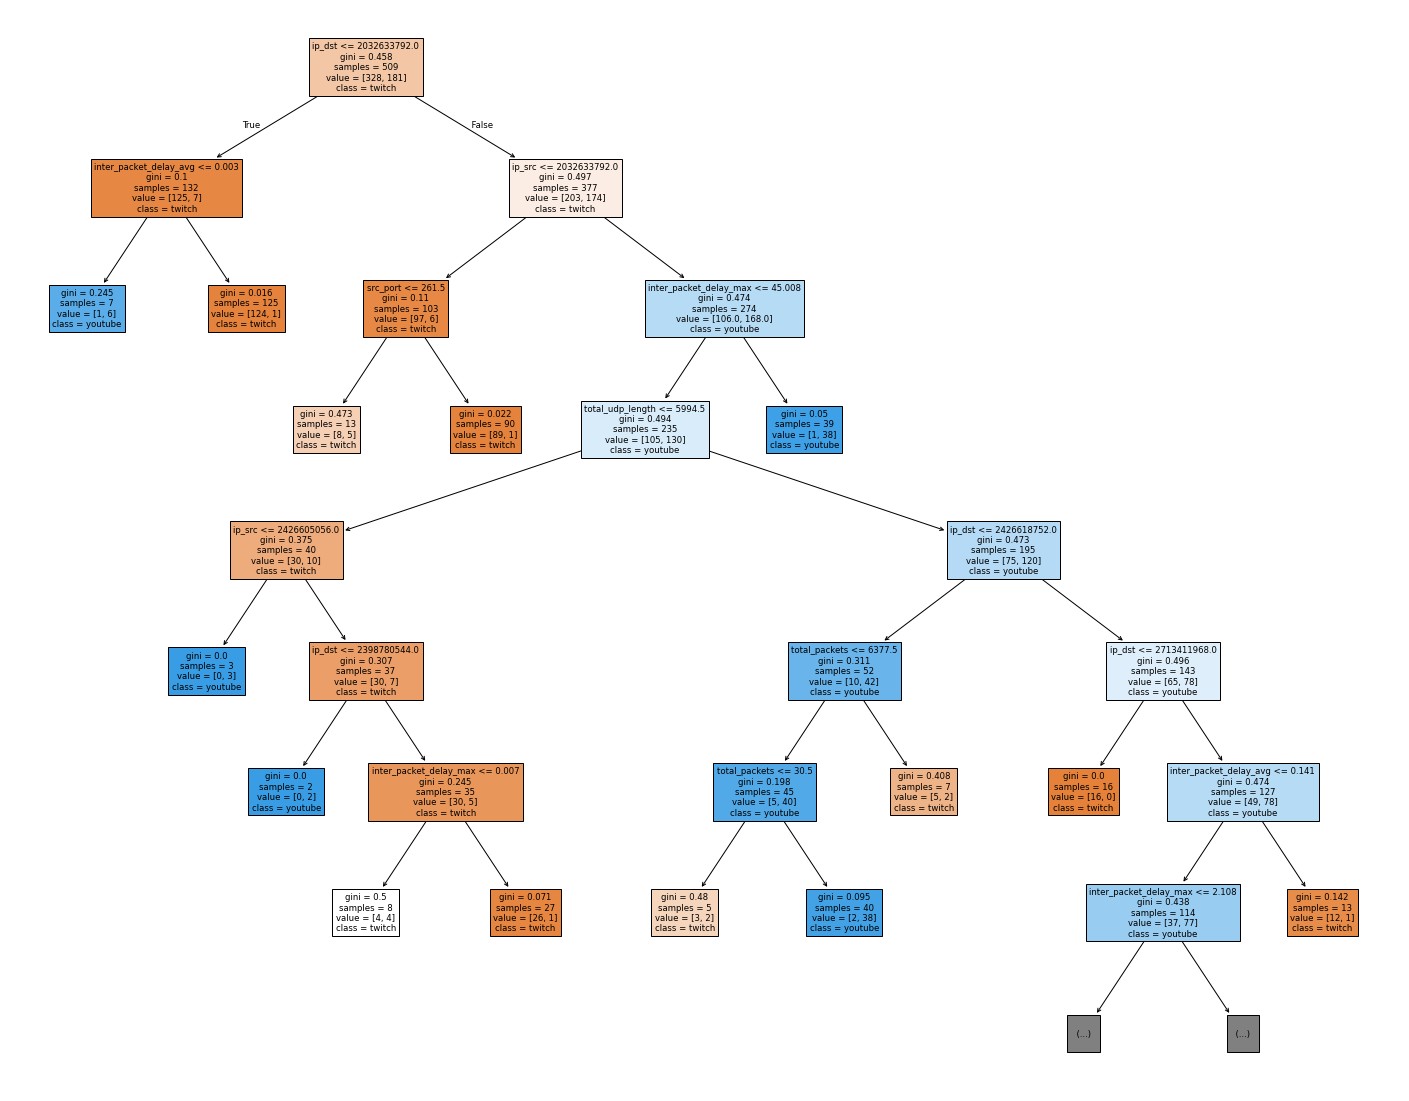

In [28]:

# Create and Train a Trustee Tree
trustee = ClassificationTrustee(expert=clf)
trustee.fit(x_train, y_train, num_samples=len(x_train) // 2, num_iter=20, train_size=0.99)

# Display Trustee Results
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_train)
print("Model explanation global fidelity report:")
print(metrics.classification_report(clf.predict(x_train), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_train, dt_y_pred))

# plot a tree
fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=sorted(all_flow_stats['Label'].unique()), filled=True, max_depth=7)

Given the report from Trustee, what feature(s) do you think are most importantly used by this classifier to predict whether a flow is Youtube or Twitch? Is this an instance of shortcut learning? Try re-training the model without including the 5-tuple for the flow as part of the list of features and observe how the decision tree changes. Why might it a bad idea to include IPs as features into this model?

### Answer:

#### **Key Features Identified**
From the Trustee report and the Decision Tree visualization:
- The most important features used by the classifier include:
  - **IP-related features (`ip_src`, `ip_dst`)**: These were prominent in the splits and played a significant role in distinguishing between Twitch and YouTube flows.
  - **Inter-packet delay metrics (`inter_packet_delay_avg`, `inter_packet_delay_max`)**: These features relate to temporal characteristics of traffic and seem to provide meaningful distinctions between Twitch and YouTube.
  - **Total UDP length** and **source port (`src_port`)**: Packet sizes and ports also contributed significantly to classification.

#### **Shortcut Learning**
This could indeed be an example of **shortcut learning** because:
- **IP addresses (`ip_src` and `ip_dst`)** might act as a proxy or shortcut to distinguish the platforms. For example:
  - If certain IP ranges are unique to Twitch or YouTube servers, the model might learn to classify based solely on these ranges, ignoring other traffic behavior features.
  - This reduces the generality of the model, as it won't perform well on flows originating from different servers (e.g., new IPs or unseen network configurations).

#### **Retraining Without IP Features**
When retraining the model without including `ip_src` and `ip_dst` as features:
1. **Expected Tree Changes:**
   - The decision tree will rely more on non-IP-related features like **inter-packet delay** and **UDP length**, leading to a deeper and potentially more robust decision structure.
   - This could also result in reduced accuracy if the non-IP features are less strongly correlated with the labels.

2. **Results from Retraining:**
   - The decision tree would likely be less precise but more generalizable since it avoids overfitting to specific server IPs. It will instead focus on traffic characteristics that are more universally applicable.

#### **Why Is Including IPs a Bad Idea?**
1. **Overfitting to Server IPs:**
   - IPs are tied to specific servers, and flows might change IPs due to load balancing or server migrations. A model trained on IPs will perform poorly in such cases.
   
2. **Lack of Generalization:**
   - Using IPs as features limits the classifier's ability to adapt to traffic from new servers or domains.

3. **Security and Privacy Concerns:**
   - IPs might inadvertently reveal information about network infrastructure or users, creating privacy risks if the model is deployed or shared.

4. **Non-Causal Relationships:**
   - The model might rely on correlations (e.g., specific IP blocks) rather than causal relationships (e.g., flow characteristics), making predictions less robust to real-world variability.

#### **Idea**
- Retrain the model without IP features and analyze the drop in performance. If the accuracy decreases significantly, consider feature engineering to improve other traffic-related metrics (e.g., packet sizes, timing data).
- Avoid using features like IPs or MAC addresses unless the application strictly requires server-specific classification.
